In [1]:
import torch
import scipy.io as sio
import numpy as np
import os
import skimage.io
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path

**Set the path to the trained model**

In [2]:
# specify the path to the pretrained model.
# modelRoot = r'flatnet_separable_pointGrey_transposeInit' ##Use this for Proposed-T
modelRoot = r'flatnet_separable_pointGrey_randomInit' ##Use this for Proposed-R

In [3]:
from skimage import transform
tform = transform.SimilarityTransform(rotation=0.00174) #to account for small rotation 

In [4]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch,momentum=0.99),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch,momentum=0.99),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

    
    
class double_conv2(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3,stride=2, padding=1),
            nn.BatchNorm2d(out_ch,momentum=0.99),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch,momentum=0.99),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x    

    
    

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            double_conv2(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3,padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [5]:
class FlatNet(nn.Module):
    def __init__(self, n_channels=4):
        super(FlatNet, self).__init__()
        self.inc = inconv(n_channels, 128)
        self.down1 = down(128, 256)
        self.down2 = down(256, 512)
        self.down3 = down(512, 1024)
        self.down4 = down(1024, 1024)
        self.up1 = up(2048, 512)
        self.up2 = up(1024, 256)
        self.up3 = up(512, 128)
        self.up4 = up(256, 128)
        self.outc = outconv(128, 3)
        self.PhiL =nn.Parameter(torch.randn(500,256,1)) 
        self.PhiR = nn.Parameter(torch.randn(620,256,1)) 
        self.bn=nn.BatchNorm2d(4,momentum=0.99)
    def forward(self, Xinp):
        
        X0 = F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,0,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
        X11 = F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,1,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
        X12 = F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,2,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
        X2 = F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,3,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
        Xout = torch.cat((X2,X12,X11,X0),3)
        x = Xout.permute(0,3,1,2)
        x = self.bn(x)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)

            
        return torch.sigmoid(x)



**Load the model and update it state dictionary with the trained state dictionary**

In [6]:
flatnet = FlatNet(4)
flatnet.load_state_dict(torch.load(modelRoot,map_location=torch.device('cpu')))
flatnet.eval()

FlatNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): double_conv2(
        (conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(256, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
 

**Function to pre-process the measurement and evaluate it**

In [7]:
def evaluate(X):
    X=X/65535.0
    X_train=np.zeros((1,4,500,620))
    im1=np.zeros((512,640,4))
    im1[:,:,0]=X[0::2, 0::2]#b
    im1[:,:,1]=X[0::2, 1::2]#gb
    im1[:,:,2]=X[1::2, 0::2]#gr
    im1[:,:,3]=X[1::2, 1::2]#r
    im1=transform.warp(im1,tform)
    im=im1[6:506,10:630,:]      
    rowMeans = im.mean(axis=1, keepdims=True)
    colMeans = im.mean(axis=0, keepdims=True)
    allMean = rowMeans.mean()
    im = im - rowMeans - colMeans + allMean

    X_train[0,:,:,:]=np.swapaxes(np.swapaxes(im,0,2),1,2)
    X_train=X_train.astype('float32')
    X_val=torch.from_numpy(X_train)
    Xvalout=flatnet(X_val)
    ims=Xvalout.detach().numpy()
    ims=np.swapaxes(np.swapaxes(ims[0,:,:,:],0,2),0,1)
    ims=(ims-np.min(ims))/(np.max(ims)-np.min(ims))
    return ims


**Load the measurement and evaluate it on the trained model**

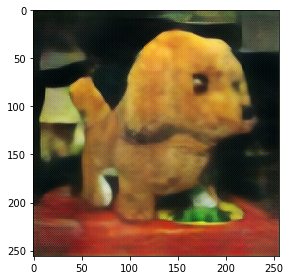

In [8]:
meas_path = Path("example_data/fc_8.png")  ## Specify the path to the measurement
X = skimage.io.imread(meas_path)
recn = evaluate(X)
skimage.io.imshow(recn)
    